In [1]:
!pip install kagglehub -q

import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [2]:
path = kagglehub.dataset_download("theblackmamba31/landscape-image-colorization")
print("Path to dataset files:", path)

# Explore directory structure
print("\nDataset structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

Path to dataset files: /kaggle/input/datasets/theblackmamba31/landscape-image-colorization

Dataset structure:
landscape-image-colorization/
  landscape Images/
    gray/
      6234.jpg
      1269.jpg
      3863.jpg
      6241.jpg
      623.jpg
      ... and 7124 more files
    color/
      6234.jpg
      1269.jpg
      3863.jpg
      6241.jpg
      623.jpg
      ... and 7124 more files


In [3]:
color_dir = None
gray_dir = None

for root, dirs, files in os.walk(path):
    if 'color' in root.lower() and any(f.endswith(('.jpg', '.jpeg', '.png')) for f in files):
        color_dir = root
    if 'gray' in root.lower() and any(f.endswith(('.jpg', '.jpeg', '.png')) for f in files):
        gray_dir = root

print(f"Color images directory: {color_dir}")
print(f"Grayscale images directory: {gray_dir}")

# Configuration
IMG_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 0.0002
BETA1 = 0.5
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\nUsing device: {DEVICE}")

Color images directory: /kaggle/input/datasets/theblackmamba31/landscape-image-colorization/landscape Images/color
Grayscale images directory: /kaggle/input/datasets/theblackmamba31/landscape-image-colorization/landscape Images/gray

Using device: cuda


In [24]:
class ColorizationDataset(Dataset):
    def __init__(self, color_dir, gray_dir, img_size=256):
        self.color_dir = color_dir
        self.gray_dir = gray_dir
        self.img_size = img_size
        
        # Get all image files
        self.color_images = sorted([f for f in os.listdir(color_dir) 
                                   if f.endswith(('.jpg', '.jpeg', '.png'))])
        self.gray_images = sorted([f for f in os.listdir(gray_dir) 
                                  if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        # Ensure we have matching pairs
        self.images = list(set(self.color_images) & set(self.gray_images))
        print(f"Found {len(self.images)} matching image pairs")
        
        # Transforms
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
        ])
        
        self.color_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load grayscale image
        gray_path = os.path.join(self.gray_dir, img_name)
        gray_img = Image.open(gray_path).convert('L')
        gray_tensor = self.transform(gray_img)
        
        # Load color image
        color_path = os.path.join(self.color_dir, img_name)
        color_img = Image.open(color_path).convert('RGB')
        color_tensor = self.color_transform(color_img)
        
        return gray_tensor, color_tensor

# Create dataset and dataloader
dataset = ColorizationDataset(color_dir, gray_dir, IMG_SIZE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")


Found 7129 matching image pairs
Dataset size: 7129
Number of batches: 446


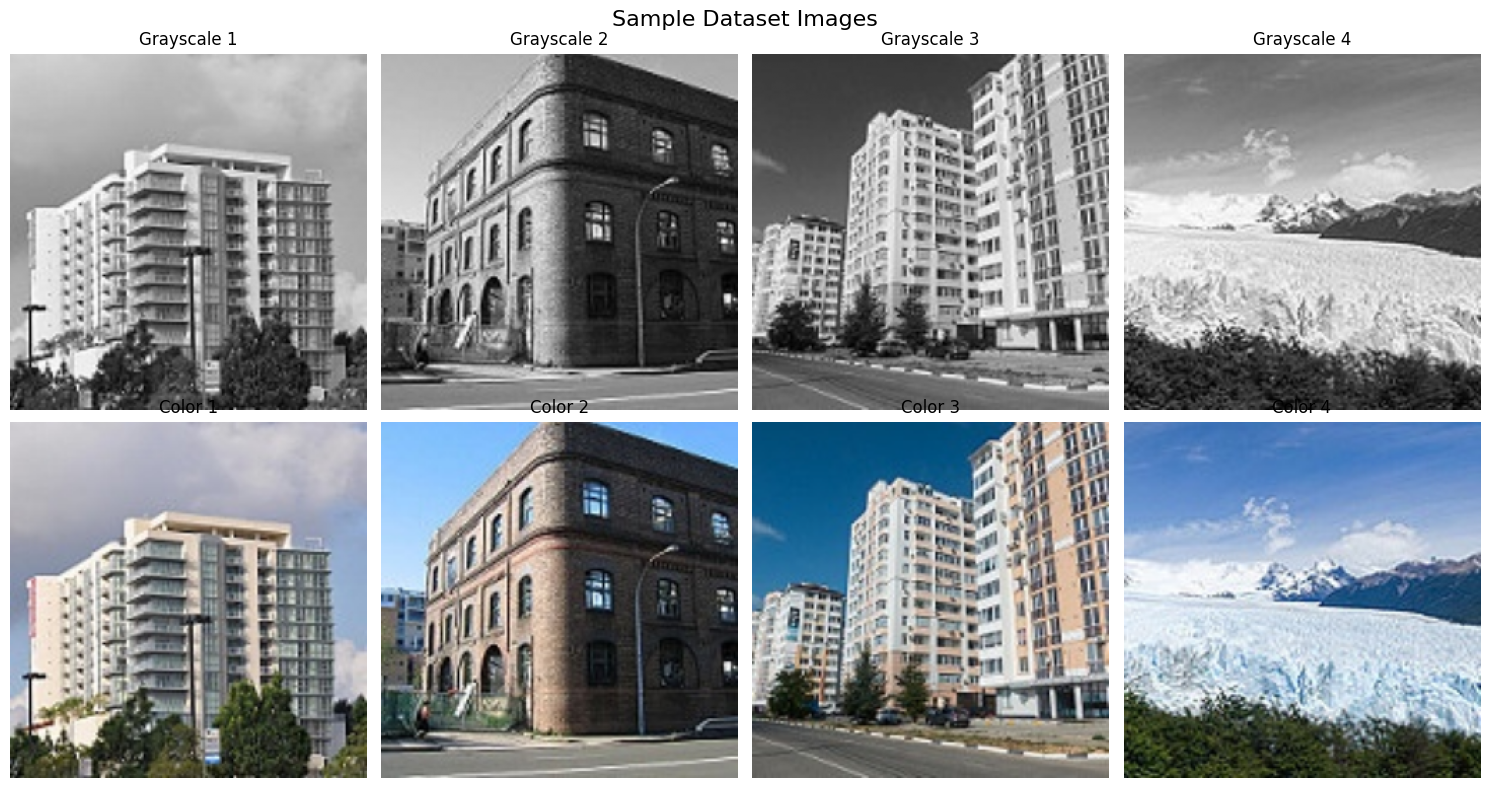

In [25]:
sample_gray, sample_color = next(iter(dataloader))

# Denormalize for visualization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Dataset Images', fontsize=16)

for i in range(4):
    # Grayscale
    gray = sample_gray[i].squeeze().cpu()
    gray = denormalize(gray.unsqueeze(0), [0.5], [0.5]).squeeze()
    axes[0, i].imshow(gray, cmap='gray')
    axes[0, i].set_title(f'Grayscale {i+1}')
    axes[0, i].axis('off')
    
    # Color
    color = sample_color[i].cpu()
    color = denormalize(color, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    color = color.permute(1, 2, 0).numpy()
    color = np.clip(color, 0, 1)
    axes[1, i].imshow(color)
    axes[1, i].set_title(f'Color {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(Generator, self).__init__()
        
        # Encoder
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        
        # Decoder
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # Decoder with skip connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        
        return self.final(u7)

# Initialize generator
generator = Generator().to(DEVICE)
print("Generator created successfully!")
print(f"Number of parameters: {sum(p.numel() for p in generator.parameters()):,}")

Generator created successfully!
Number of parameters: 54,411,907


In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=4):  # 1 (gray) + 3 (color) = 4
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )
    
    def forward(self, img_gray, img_color):
        # Concatenate grayscale and color images
        img_input = torch.cat((img_gray, img_color), 1)
        return self.model(img_input)

# Initialize discriminator
discriminator = Discriminator().to(DEVICE)
print("Discriminator created successfully!")
print(f"Number of parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


Discriminator created successfully!
Number of parameters: 2,767,552


In [8]:
criterion_GAN = nn.MSELoss()
criterion_pixelwise = nn.L1Loss()

# Loss weight for L1 pixel-wise loss
lambda_pixel = 100

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))

print("Loss functions and optimizers initialized!")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Lambda pixel: {lambda_pixel}")

Loss functions and optimizers initialized!
Learning rate: 0.0002
Lambda pixel: 100


In [9]:
def train_epoch(generator, discriminator, dataloader, optimizer_G, optimizer_D, 
                criterion_GAN, criterion_pixelwise, lambda_pixel, device):
    generator.train()
    discriminator.train()
    
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    pbar = tqdm(dataloader, desc='Training')
    
    for i, (gray_imgs, color_imgs) in enumerate(pbar):
        gray_imgs = gray_imgs.to(device)
        color_imgs = color_imgs.to(device)
        
        batch_size = gray_imgs.size(0)
        
        # Get discriminator output size dynamically
        with torch.no_grad():
            sample_output = discriminator(gray_imgs[:1], color_imgs[:1])
            patch_h, patch_w = sample_output.shape[2], sample_output.shape[3]
        
        # Real and fake labels
        valid = torch.ones(batch_size, 1, patch_h, patch_w, requires_grad=False).to(device)
        fake = torch.zeros(batch_size, 1, patch_h, patch_w, requires_grad=False).to(device)
        
        # ==================
        # Train Generator
        # ==================
        optimizer_G.zero_grad()
        
        # Generate colorized images
        gen_imgs = generator(gray_imgs)
        
        # GAN loss
        pred_fake = discriminator(gray_imgs, gen_imgs)
        loss_GAN = criterion_GAN(pred_fake, valid)
        
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(gen_imgs, color_imgs)
        
        # Total generator loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel
        
        loss_G.backward()
        optimizer_G.step()
        
        # =====================
        # Train Discriminator
        # =====================
        optimizer_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(gray_imgs, color_imgs)
        loss_real = criterion_GAN(pred_real, valid)
        
        # Fake loss
        pred_fake = discriminator(gray_imgs, gen_imgs.detach())
        loss_fake = criterion_GAN(pred_fake, fake)
        
        # Total discriminator loss
        loss_D = (loss_real + loss_fake) / 2
        
        loss_D.backward()
        optimizer_D.step()
        
        # Update losses
        epoch_g_loss += loss_G.item()
        epoch_d_loss += loss_D.item()
        
        # Update progress bar
        pbar.set_postfix({
            'G_loss': f'{loss_G.item():.4f}',
            'D_loss': f'{loss_D.item():.4f}'
        })
    
    return epoch_g_loss / len(dataloader), epoch_d_loss / len(dataloader)

print("Training functions defined!")

Training functions defined!


In [10]:
def visualize_results(generator, dataloader, device, num_images=4):
    generator.eval()
    
    # Get a batch of images
    gray_imgs, color_imgs = next(iter(dataloader))
    gray_imgs = gray_imgs[:num_images].to(device)
    color_imgs = color_imgs[:num_images].to(device)
    
    with torch.no_grad():
        gen_imgs = generator(gray_imgs)
    
    # Move to CPU and denormalize
    gray_imgs = gray_imgs.cpu()
    color_imgs = color_imgs.cpu()
    gen_imgs = gen_imgs.cpu()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 11))
    fig.suptitle('Colorization Results', fontsize=16)
    
    for i in range(num_images):
        # Grayscale input
        gray = gray_imgs[i].squeeze()
        gray = denormalize(gray.unsqueeze(0), [0.5], [0.5]).squeeze()
        axes[0, i].imshow(gray, cmap='gray')
        axes[0, i].set_title('Input (Gray)')
        axes[0, i].axis('off')
        
        # Generated color
        gen = gen_imgs[i]
        gen = denormalize(gen, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        gen = gen.permute(1, 2, 0).numpy()
        gen = np.clip(gen, 0, 1)
        axes[1, i].imshow(gen)
        axes[1, i].set_title('Generated')
        axes[1, i].axis('off')
        
        # Ground truth
        color = color_imgs[i]
        color = denormalize(color, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        color = color.permute(1, 2, 0).numpy()
        color = np.clip(color, 0, 1)
        axes[2, i].imshow(color)
        axes[2, i].set_title('Ground Truth')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    generator.train()

print("Visualization function defined!")

Visualization function defined!


In [11]:
RESUME_CHECKPOINT = None  # Change this or set to None

# RESUME_CHECKPOINT = None  # Uncomment this line to start training from scratch

start_epoch = 0
g_losses = []
d_losses = []

if RESUME_CHECKPOINT is not None and os.path.exists(RESUME_CHECKPOINT):
    print(f"{'='*60}")
    print(f"RESUMING TRAINING FROM CHECKPOINT")
    print(f"{'='*60}")
    print(f"Loading checkpoint: {RESUME_CHECKPOINT}")
    
    try:
        checkpoint = torch.load(RESUME_CHECKPOINT, map_location=DEVICE)
        
        # Load model weights
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        
        # Load optimizer states
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        
        # Get starting epoch
        start_epoch = checkpoint['epoch'] + 1
        
        print(f"✓ Checkpoint loaded successfully!")
        print(f"✓ Last completed epoch: {checkpoint['epoch'] + 1}")
        print(f"✓ Resuming from epoch: {start_epoch + 1}")
        print(f"✓ Will train until epoch: {EPOCHS}")
        print(f"✓ Remaining epochs: {EPOCHS - start_epoch}")
        print(f"{'='*60}\n")
        
    except Exception as e:
        print(f"❌ Error loading checkpoint: {e}")
        print("Starting training from scratch...")
        start_epoch = 0
else:
    print(f"{'='*60}")
    print("STARTING TRAINING FROM SCRATCH")
    print(f"{'='*60}")
    print(f"Training for {EPOCHS} epochs")
    print(f"{'='*60}\n")

STARTING TRAINING FROM SCRATCH
Training for 10 epochs



Starting training from epoch 1 to 10
Device: cuda

Epoch [1/10]


Training: 100%|██████████| 446/446 [01:44<00:00,  4.25it/s, G_loss=11.9251, D_loss=0.0552]


Generator Loss: 14.3734 | Discriminator Loss: 0.1558

Epoch [2/10]


Training: 100%|██████████| 446/446 [01:43<00:00,  4.30it/s, G_loss=12.4714, D_loss=0.0487]


Generator Loss: 11.6924 | Discriminator Loss: 0.1403

Epoch [3/10]


Training: 100%|██████████| 446/446 [01:43<00:00,  4.29it/s, G_loss=9.4849, D_loss=0.1239] 


Generator Loss: 11.3308 | Discriminator Loss: 0.1378

Epoch [4/10]


Training: 100%|██████████| 446/446 [01:43<00:00,  4.29it/s, G_loss=10.5052, D_loss=0.2531]


Generator Loss: 11.0624 | Discriminator Loss: 0.1347

Epoch [5/10]


Training: 100%|██████████| 446/446 [01:43<00:00,  4.29it/s, G_loss=10.0419, D_loss=0.1721]

Generator Loss: 10.9592 | Discriminator Loss: 0.1334

Generating sample images...


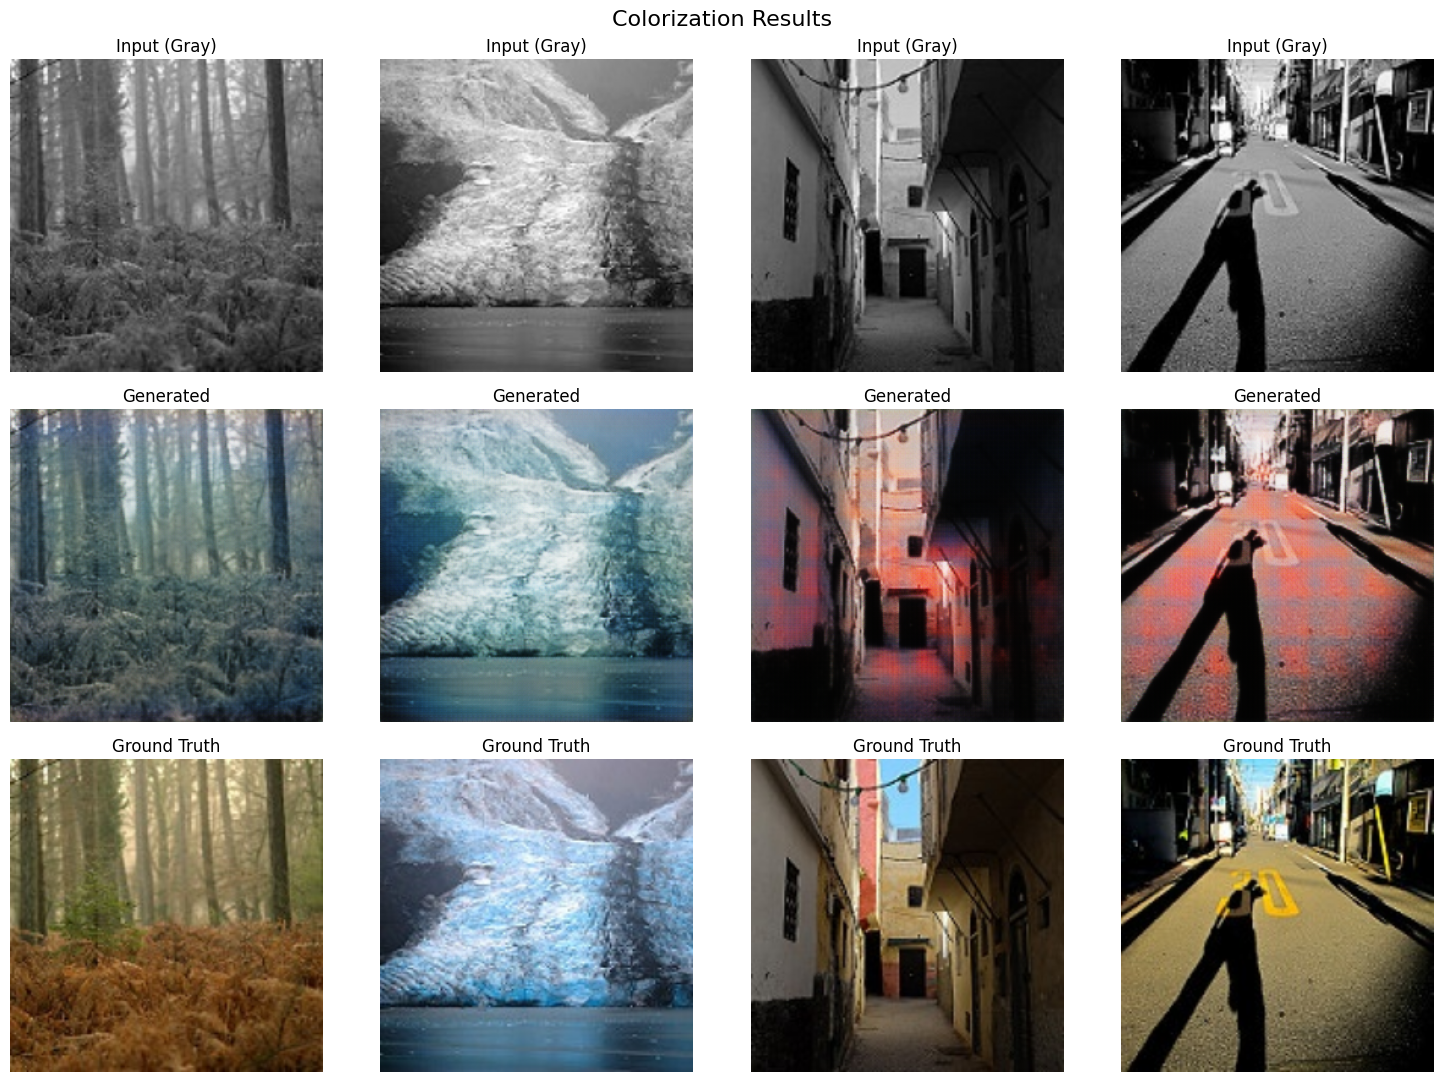


Epoch [6/10]


Training: 100%|██████████| 446/446 [01:44<00:00,  4.28it/s, G_loss=10.5368, D_loss=0.1018]


Generator Loss: 10.8472 | Discriminator Loss: 0.1352

Epoch [7/10]


Training: 100%|██████████| 446/446 [01:44<00:00,  4.28it/s, G_loss=12.7990, D_loss=0.1245]


Generator Loss: 10.6394 | Discriminator Loss: 0.1368

Epoch [8/10]


Training: 100%|██████████| 446/446 [01:44<00:00,  4.28it/s, G_loss=10.3445, D_loss=0.0610]


Generator Loss: 10.5287 | Discriminator Loss: 0.1385

Epoch [9/10]


Training: 100%|██████████| 446/446 [01:44<00:00,  4.29it/s, G_loss=9.2323, D_loss=0.0794] 


Generator Loss: 10.4149 | Discriminator Loss: 0.1359

Epoch [10/10]


Training: 100%|██████████| 446/446 [01:43<00:00,  4.29it/s, G_loss=11.1934, D_loss=0.1365]

Generator Loss: 10.3312 | Discriminator Loss: 0.1389

Generating sample images...


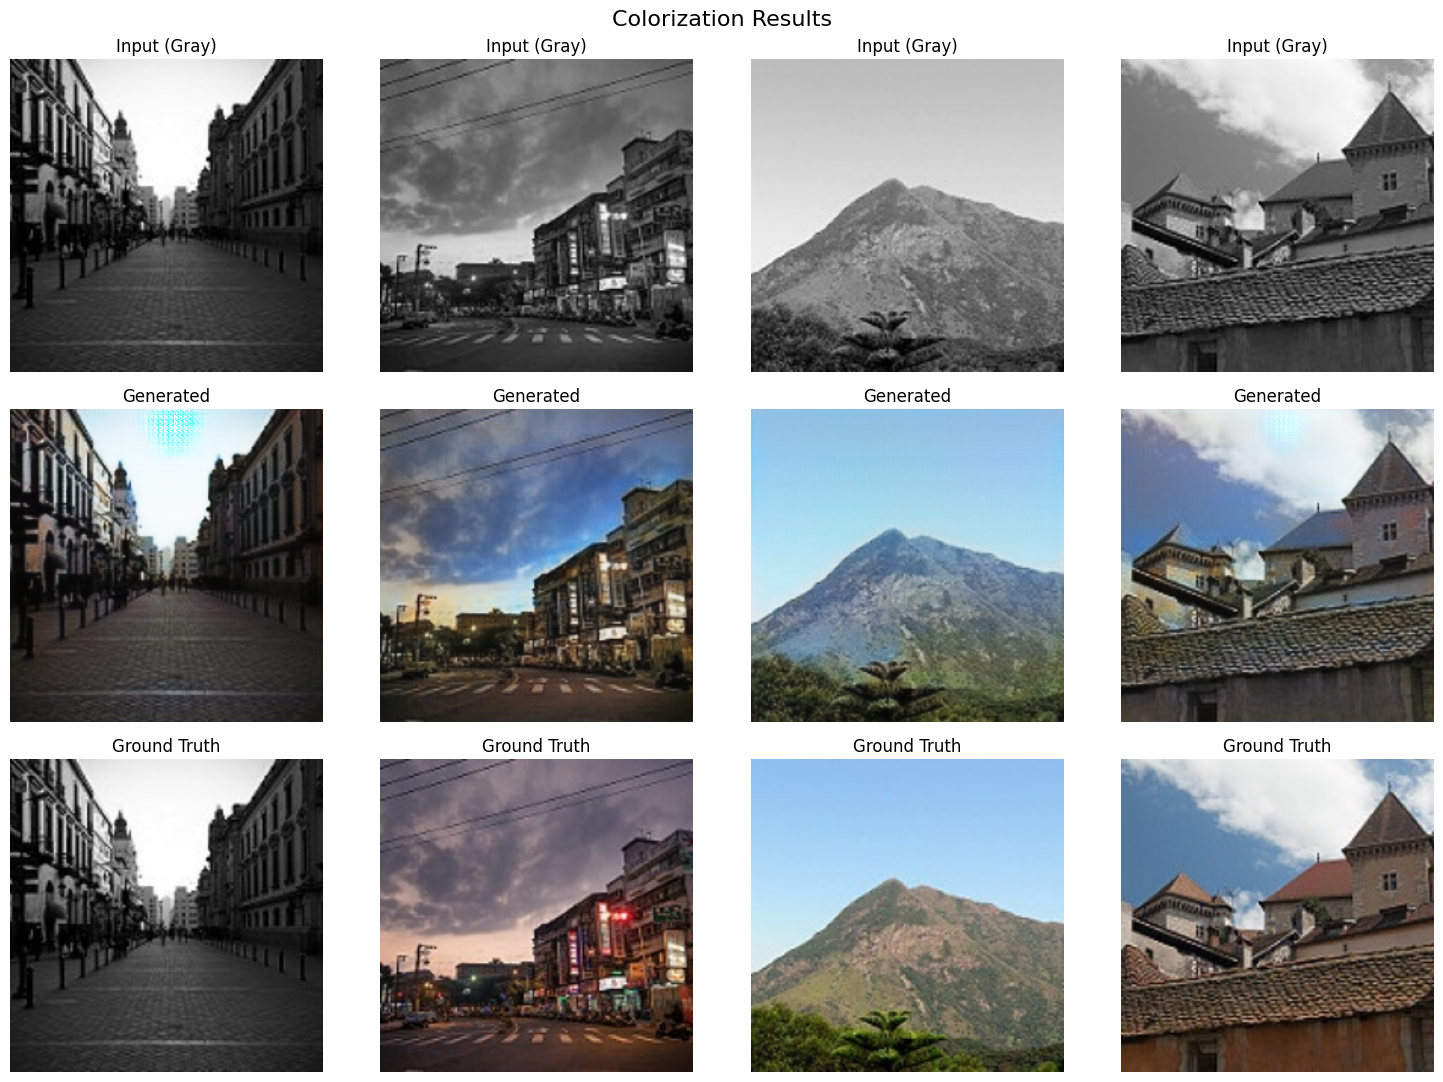

Checkpoint saved: colorization_checkpoint_epoch_10.pth

Training completed!


In [12]:
if start_epoch == 0:
    g_losses = []
    d_losses = []

print(f"Starting training from epoch {start_epoch + 1} to {EPOCHS}")
print(f"Device: {DEVICE}")
print("=" * 60)

for epoch in range(start_epoch, EPOCHS):  # Changed: start from start_epoch instead of 0
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
    
    # Train for one epoch
    g_loss, d_loss = train_epoch(
        generator, discriminator, dataloader,
        optimizer_G, optimizer_D,
        criterion_GAN, criterion_pixelwise,
        lambda_pixel, DEVICE
    )
    
    # Store losses
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    
    print(f"Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}")
    
    # Visualize results every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nGenerating sample images...")
        visualize_results(generator, dataloader, DEVICE)
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'g_loss': g_loss,
            'd_loss': d_loss
        }
        torch.save(checkpoint, f'colorization_checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved: colorization_checkpoint_epoch_{epoch+1}.pth")

print("\n" + "=" * 60)
print("Training completed!")

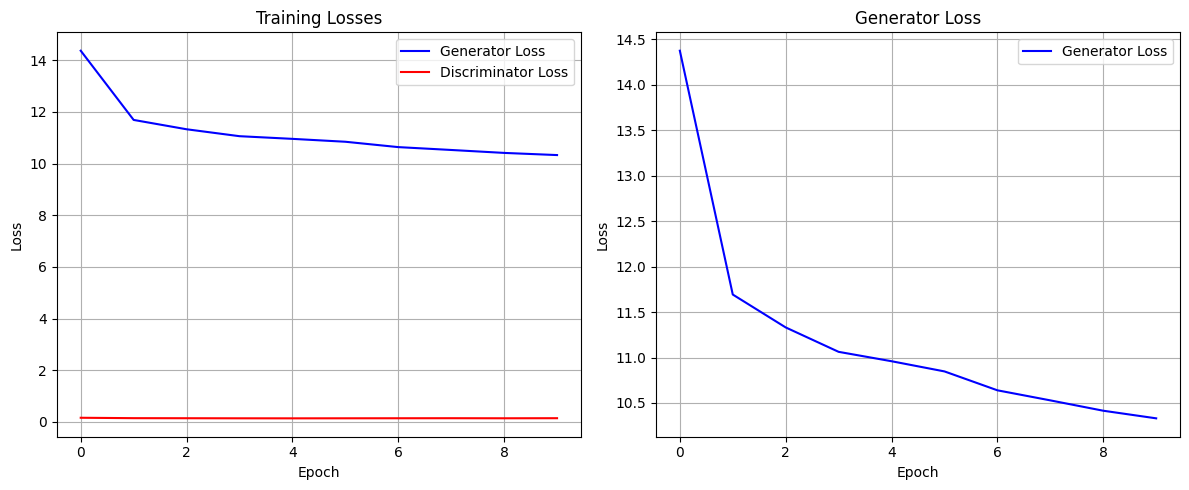

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(g_losses, label='Generator Loss', color='blue')
plt.plot(d_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(g_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Generating final results...


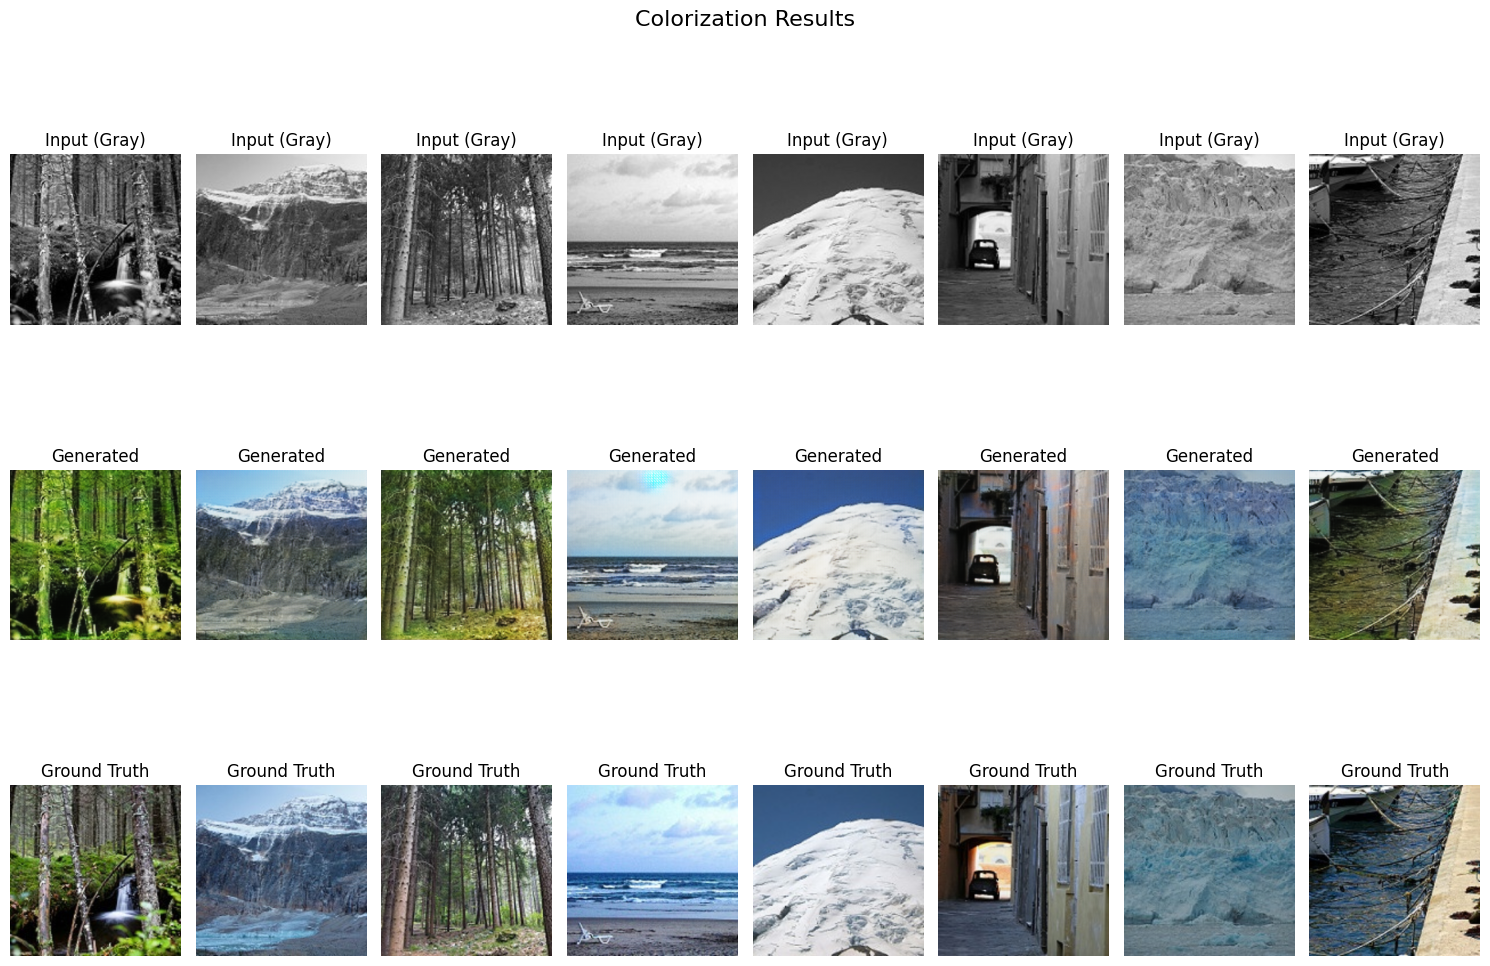

In [15]:
print("Generating final results...")
visualize_results(generator, dataloader, DEVICE, num_images=8)

In [16]:
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
}, 'final_colorization_model.pth')

print("Final model saved as 'final_colorization_model.pth'")

Final model saved as 'final_colorization_model.pth'


In [17]:
def colorize_image(generator, image_path, device, img_size=256):
    """Colorize a single grayscale image"""
    generator.eval()
    
    # Load and preprocess image
    img = Image.open("/kaggle/input/testeddata/download (1).jpeg").convert('L')
    
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])  
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Generate colorized image
    with torch.no_grad():
        colorized = generator(img_tensor)
    
    # Post-process
    colorized = colorized.cpu().squeeze()
    colorized = denormalize(colorized, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    colorized = colorized.permute(1, 2, 0).numpy()
    colorized = np.clip(colorized, 0, 1)
    
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Input (Grayscale)')
    axes[0].axis('off')
    
    axes[1].imshow(colorized)
    axes[1].set_title('Colorized Output')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return colorized

print("Inference function ready!")
print("\nTo colorize a new image, use:")
print("colorized_img = colorize_image(generator, 'path/to/image.jpg', DEVICE)")

print("\n" + "=" * 60)
print("All cells executed successfully!")
print("GAN-based Image Colorization model is ready to use!")
print("=" * 60)

Inference function ready!

To colorize a new image, use:
colorized_img = colorize_image(generator, 'path/to/image.jpg', DEVICE)

All cells executed successfully!
GAN-based Image Colorization model is ready to use!


In [26]:
def colorize_image(image_path, save_path=None):
    """
    Colorize a grayscale image
    
    Args:
        image_path: Path to grayscale input image
        save_path: Optional path to save colorized image
    
    Returns:
        colorized_image: Numpy array of colorized image
    """
    
    # Load image
    try:
        img = Image.open(image_path).convert('L')  # Force grayscale
        print(f"✓ Loaded image: {image_path}")
        print(f"  Original size: {img.size}")
    except Exception as e:
        print(f"❌ Error loading image: {e}")
        return None
    
    original_size = img.size
    
    # Preprocess
    IMG_SIZE = 256
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    gray_tensor = transform(img).unsqueeze(0).to(DEVICE)
    
    # Generate colorized image
    print("⏳ Generating colors...")
    with torch.no_grad():
        colorized_tensor = generator(gray_tensor)
    
    # Post-process
    colorized_tensor = colorized_tensor.cpu().squeeze()
    
    # Denormalize
    colorized_tensor = colorized_tensor * 0.5 + 0.5
    colorized_tensor = torch.clamp(colorized_tensor, 0, 1)
    
    # Convert to numpy
    colorized_np = colorized_tensor.permute(1, 2, 0).numpy()
    
    # Resize back to original size
    colorized_pil = Image.fromarray((colorized_np * 255).astype(np.uint8))
    colorized_pil = colorized_pil.resize(original_size, Image.LANCZOS)
    colorized_np_full = np.array(colorized_pil) / 255.0
    
    # Display results - Only show grayscale input and colorized output
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Grayscale input
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Grayscale Input', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Colorized output
    axes[1].imshow(colorized_np_full)
    axes[1].set_title('Colorized Output', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save if path provided
    if save_path:
        colorized_pil.save(save_path)
        print(f"✓ Colorized image saved to: {save_path}")
    
    print("✓ Colorization complete!")
    return colorized_np_full

print("✓ Colorization function ready!")

✓ Colorization function ready!


Starting colorization...
✓ Loaded image: /kaggle/input/datasets/shashankgowdarvu/testing/download (1).jpg
  Original size: (275, 183)
⏳ Generating colors...


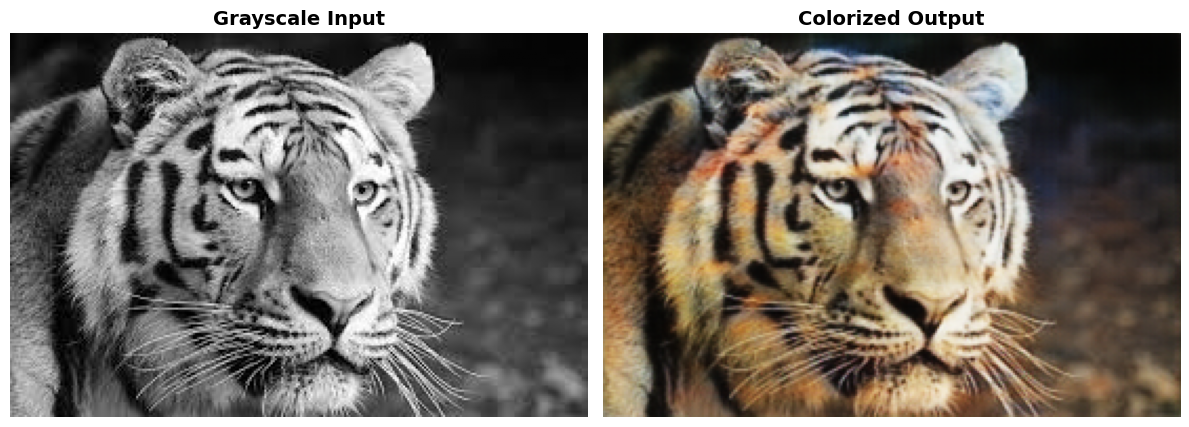

✓ Colorization complete!


In [30]:
# SET YOUR IMAGE PATH HERE
TEST_IMAGE_PATH = '/kaggle/input/datasets/shashankgowdarvu/testing/download (1).jpg'  # Change this to your image path

# Optional: Set save path for output
OUTPUT_PATH = None  # Change this or set to None

# Run colorization
print("="*60)
print("Starting colorization...")
print("="*60)

colorized = colorize_image(TEST_IMAGE_PATH, save_path=OUTPUT_PATH)